# Logistic Regression for E-Commerce

## Introduction
An e-commerce company has developed a new web page in order to try and increase purchases (conversions) made through their site. They have run an AB experiment and collected data regarding the number of conversions for a control group and a treatment group. The objective of this project is to assess the data and help the company understand if they should implement this new page, keep the old page, or run the experiment longer to make their decision.

In the [AB_Test notebook](http://localhost:8888/notebooks/notebooks/AB_Test.ipynb), we analysed the results of an A/B test experiment run by an e-commerce website. We found that, based on a type 1 error rate threshold of 5%, we cannot state with statsitcal significance that the new page performs differently to the old page and made the recommendation that the new page is not implemented. 

In this notebook, we build a logisitic regression model to predict the probability of individual user conversion. This model may help the e-commerce site understand which users are most and least likely to make a purchase and implement their marketing strategies accordingly.


## Data Overview
The datasets for this project are provided by **Udacity** in association with their **Data Analyst Nanodegree** programme. They have been generated to represent example A/B experiment results from an e-commerce website. There are 2 raw csv files:

  * `ab_test.csv` - contains information regarding the group (control or treatment), landing page (old or new), timestamp of visit and conversion.
  * `countries.csv` - contains information regarding the country of origin of each user.
  
In [AB_Test notebook](http://localhost:8888/notebooks/notebooks/AB_Test.ipynb), we cleaned the above dataframes and saved to `ab_data_clean.csv`. We'll be using this for our assessments in this notebook.
  
***
## Regression Analysis
Given that user conversion is binary, another method we can use to investigate the probability of conversion is logistic regression. To reinforce conceptual understanding of logistic regression algorithms we will build them from scratch then compare and optimise performance. 

Model plan:
* Engineer features in ab_test_clean.csv
* Divide the dataset randomly into a 70:30 training and test set split
* Train unregularised logistic regression model. Assess performance against mutliple learning rates $\alpha$
* Train regularised logistic regression model. Compare training accuracy for multiple values of $\lambda$

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import os
import sys

%matplotlib inline

path = os.path.abspath(os.path.join('../features'))
if path not in sys.path:
    sys.path.append(path)
    
# Custom libraries
import visualise as vis
import model as mod

# Seed random to keep values common for each execution
np.random.seed(42)

In [2]:
df_mod = pd.read_csv('../data/ab_data_clean.csv')
df_mod.timestamp = pd.to_datetime(df_mod.timestamp)

In [3]:
# Create dummy variables
df_mod[['CA', 'UK','US']] = pd.get_dummies(df_mod.country)
df_mod.group = np.where(df_mod.group=='control', 0, 1)
df_mod.head()

,user_id,timestamp,group,landing_page,converted,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,0,old_page,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,0,old_page,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,1,new_page,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,1,new_page,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,0,old_page,1,US,0,0,1


In order to use `timestamp` as a feature we'll need to group the values. Lets first look at the range.

In [4]:
print(df_mod.timestamp.max())
print(df_mod.timestamp.min())

2017-01-24 13:41:54.460509
2017-01-02 13:42:05.378582


Here we can see that the AB data was collected between 2017-01-02 and 2017-01-24. Grouping the timestamps by day will help us map out the engagement over the full course of the experiment. Grouping the timestamps by hours might also be useful for predicting conversion rates. **However**, we are missing some crucial information, we do not know what timezone this timestamp refers to, or whether the timezone is consistent throughout. We'll need to understand this information to properly validate the prediction model.

In [5]:
# extract day
df_mod['day'] = df_mod.timestamp.dt.day
# extract hour
df_mod['hour'] = df_mod.timestamp.dt.hour
# create intercept, x0
df_mod['intercept'] = 1
df_mod.head()

,user_id,timestamp,group,landing_page,converted,country,CA,UK,US,day,hour,intercept
0,851104,2017-01-21 22:11:48.556739,0,old_page,0,US,0,0,1,21,22,1
1,804228,2017-01-12 08:01:45.159739,0,old_page,0,US,0,0,1,12,8,1
2,661590,2017-01-11 16:55:06.154213,1,new_page,0,US,0,0,1,11,16,1
3,853541,2017-01-08 18:28:03.143765,1,new_page,0,US,0,0,1,8,18,1
4,864975,2017-01-21 01:52:26.210827,0,old_page,1,US,0,0,1,21,1,1


Finally lets reorder our columns, keeping only features we want to include in the model.

In [6]:
cols = ['intercept', 'group', 'CA', 'UK','US','day', 'hour','converted']
df_mod = df_mod[cols]
df_mod.head()

,intercept,group,CA,UK,US,day,hour,converted
0,1,0,0,0,1,21,22,0
1,1,0,0,0,1,12,8,0
2,1,1,0,0,1,11,16,0
3,1,1,0,0,1,8,18,0
4,1,0,0,0,1,21,1,1


Now lets split our data into a training and testing sets on a 70:30 split and convert to numpy matrices.

In [7]:
df_train = df_mod.sample(frac=0.7, replace=False, random_state=42)
idx = df_train.index
# Drop all examples which are in df_train
df_test = df_mod.drop(idx)

In [8]:
# Confirm 70:30 split of data
print(df_train.shape[0]/df_mod.shape[0], df_test.shape[0]/df_mod.shape[0])

# Confirm all data is included in df_train and df_test
assert (df_train.shape[0]+df_test.shape[0] == df_mod.shape[0])

0.7000006882691407 0.29999931173085925


In [9]:
X_train, y_train = df_train.iloc[:,:-1].values, df_train.converted.values
X_test, y_test = df_test.iloc[:,:-1].values, df_test.converted.values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((203409, 7), (203409,), (87175, 7), (87175,))

Now that our training and test data is set up as matrices we can run our model. We'll start by initialising `theta` to zero's, then assess gradient descent performance with a number of different learning rates.

In [10]:
# Initialise theta to zero
theta = np.zeros(X_train.shape[1])

In [61]:
%%time
theta_opt01, costs01 = mod.gradientDescent(X_train, theta, y_train, alpha=0.01, track=True, iters=500)

CPU times: user 33.2 s, sys: 47.7 ms, total: 33.2 s
Wall time: 8.37 s


In [11]:
%%time
theta_opt03, costs03 = mod.gradientDescent(X_train, theta, y_train, alpha=0.03, track=True, iters=500)

CPU times: user 37.1 s, sys: 39.6 ms, total: 37.1 s
Wall time: 9.32 s


In [122]:
%%time
theta_opt06, costs06 = mod.gradientDescent(X_train, theta, y_train, alpha=0.06, track=True, iters=500)

CPU times: user 28.3 s, sys: 0 ns, total: 28.3 s
Wall time: 7.09 s


In [63]:
%%time
theta_opt1, costs1 = mod.gradientDescent(X_train, theta, y_train, alpha=0.1, track=True, iters=500)

CPU times: user 29.6 s, sys: 23.8 ms, total: 29.6 s
Wall time: 7.4 s


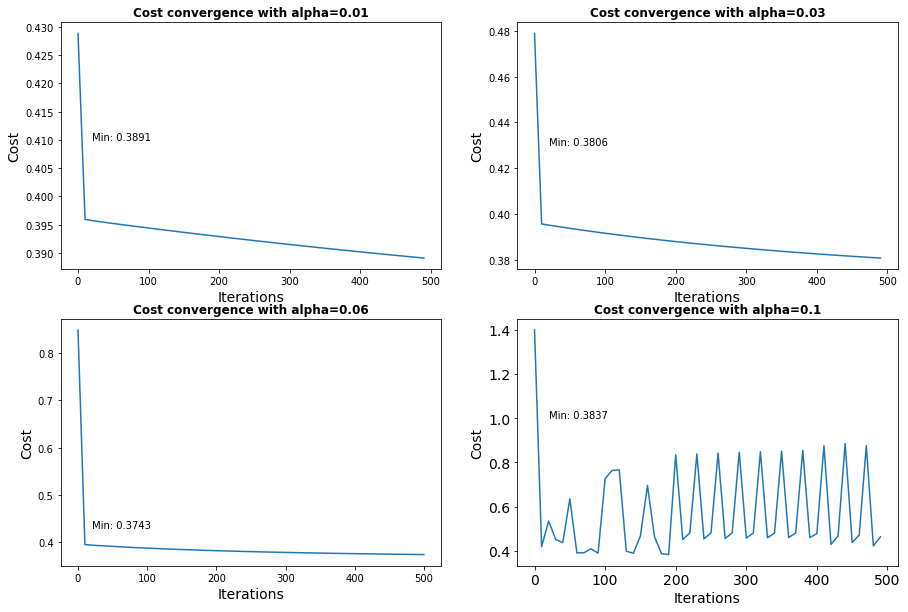

In [153]:
x01 = [i*10 for i, j in enumerate(costs01)]
y01 = [j for i, j in enumerate(costs01)]

x03 = [i*10 for i, j in enumerate(costs03)]
y03 = [j for i, j in enumerate(costs03)]

x06 = [i*10 for i, j in enumerate(costs06)]
y06 = [j for i, j in enumerate(costs06)]

x1 = [i*10 for i, j in enumerate(costs1)]
y1 = [j for i, j in enumerate(costs1)]

titles= ["Cost convergence with alpha=0.01", "Cost convergence with alpha=0.03", 
         "Cost convergence with alpha=0.06", "Cost convergence with alpha=0.1"]


axs = vis.createPlot(r=2,c=2,title=titles, figsize=[15,10], xlabel="Iterations", ylabel='Cost', sharey=False,
                    title_font=12)

plt.sca(axs[0])
sb.lineplot(x=x01,y=y01)
plt.text(20,0.41,"Min: {:.4f}".format(np.min(costs01)));

plt.sca(axs[1])
sb.lineplot(x=x03,y=y03)
plt.text(20,0.43,"Min: {:.4f}".format(np.min(costs03)));

plt.sca(axs[2])
sb.lineplot(x=x06,y=y06)
plt.text(20,0.43,"Min: {:.4f}".format(np.min(costs06)));

plt.sca(axs[3])
sb.lineplot(x=x1,y=y1)
plt.text(20,1.0,"Min: {:.4f}".format(np.min(costs1)));

### Performance
* $\alpha = 0.1$ failed to converge
* $\alpha = 0.01$, $\alpha = 0.03$ are not fully converged after 500 iterations
* $\alpha = 0.06$ appears to be almost fully converged after 500 iterations
* The computations executed in 33, 30, 28 and 29 seconds.
*** 
Lets reassess learning rate 0.03 and 0.06 using 1000 iterations

In [116]:
%%time
theta_opt03_1000, costs03_1000 = mod.gradientDescent(X_train, theta, y_train, alpha=0.03, track=True, iters=1000)

CPU times: user 55.3 s, sys: 15.9 ms, total: 55.3 s
Wall time: 13.8 s


In [154]:
%%time
theta_opt06_1000, costs06_1000 = mod.gradientDescent(X_train, theta, y_train, alpha=0.06, track=True, iters=1000)

CPU times: user 55.6 s, sys: 83.8 ms, total: 55.7 s
Wall time: 14 s


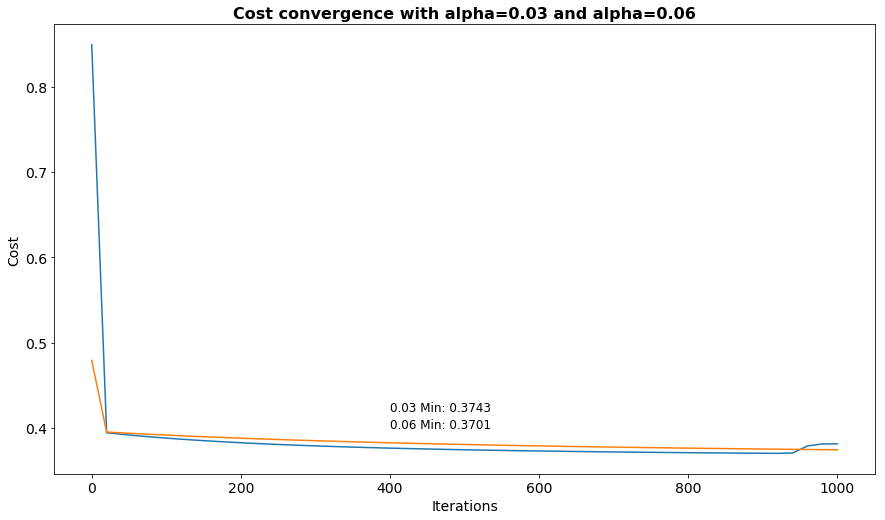

In [262]:
x03 = [i*20 for i, j in enumerate(costs03_1000)]
y03 = [j for i, j in enumerate(costs03_1000)]

x06 = [i*20 for i, j in enumerate(costs06_1000)]
y06 = [j for i, j in enumerate(costs06_1000)]

titles= ["Cost convergence with alpha=0.03 and alpha=0.06"]

axs = vis.createPlot(1,1,title=titles, xlabel="Iterations", ylabel='Cost', sharey=True)

sb.lineplot(x=x06,y=y06)
sb.lineplot(x=x03,y=y03)
plt.text(400,0.40,"0.06 Min: {:.4f}".format(np.min(costs06_1000)), fontsize=12);
plt.text(400,0.42,"0.03 Min: {:.4f}".format(np.min(costs03_1000)), fontsize=12);


### Performance
* $\alpha = 0.06$ appears to converge to a minimum of 0.3701 before **diverging**
* $\alpha = 0.03$ has a higher minimum than the $\alpha = 0.06$ and is still converging.
* The computations executed in 55.3, 55.6 seconds.
*** 
To minimise risk of divergence we'll select a learning rate $\alpha$ of 0.03. Lets inspect the convergence as we increase the number of iterations to 2000.

In [12]:
%%time
theta_opt03_2000, costs03_2000 = mod.gradientDescent(X_train, theta, y_train, alpha=0.03, track=True, iters=2000)

CPU times: user 1min 51s, sys: 16 ms, total: 1min 51s
Wall time: 27.9 s


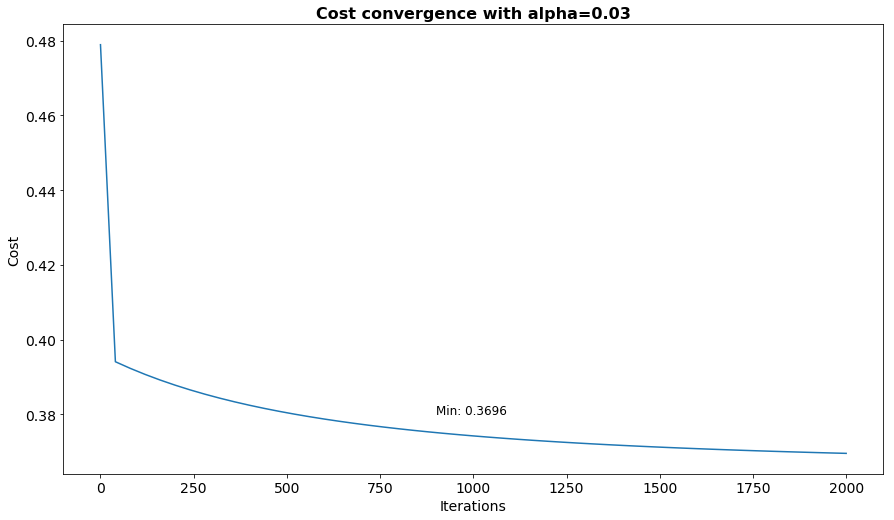

In [22]:
x03_2000 = [i*40 for i, j in enumerate(costs03_2000)]
y03_2000 = [j for i, j in enumerate(costs03_2000)]

title= ["Cost convergence with alpha=0.03", "Cost convergence with alpha=0.06"]

axs = vis.createPlot(1,1,title=title, xlabel="Iterations", ylabel='Cost')

sb.lineplot(x=x03_2000,y=y03_2000)
plt.text(900,0.38,"Min: {:.4f}".format(np.min(costs03_2000)), fontsize=12);

### Performance
* $\alpha = 0.03$ converges to 0.3696 after 2000 iterations and 0.3806 after 500 iterations.
* The computations executed in 1 minute 55 seconds and 30 seconds respectively.
* Thess computation times should increase in speed significantly when we do not track the cost.
***
Lets now calculate our prediction accuracy using our theta parameter optimised over 2000 iterations.

In [13]:
# Predictions with theta optimised with 2000 iterations
predict_train2000 = mod.predict(X_train, theta_opt03_2000)
predict_test2000 = mod.predict(X_test, theta_opt03_2000)

print("train:", mod.predictAccuray(predict_train2000, y_train), 
          "test:", mod.predictAccuray(predict_test2000, y_test))

print("Convertions predicted:", predict_train2000.sum())

train: 88.02% test: 88.09%
Convertions predicted: 0


Initially it seems that we have a good train and test accuracy of 88%, however, the model has failed to predict any positive conversions at all. We discovered in the A/B investigation that 12% of the total sample converted, therefore predicting all negative cases gives us the 88% accuracy seen here. Lets us the $F_1$ score as an alternative metric.

$$Precision (P) = \frac{True Positives}{True Positives + False Positives}$$

$$Recall (R) = \frac{True Positives}{True Positives + False Negatives}$$

$$F_1 = 2\frac{PR}{P+R}$$

Because the model predicts no positive results, we have an $F_1$ score of zero. We need to optimise the prediction threshold since there are no examples with a sigmoid value greater than 0.5.

In [48]:
mod.sigmoid(X_train, theta_opt03_2000).max(), mod.sigmoid(X_train, theta_opt03_2000).min()

(0.24115040000674867, 0.07653980079999573)

In [34]:
import importlib
importlib.reload(mod)

<module 'model' from '/home/ding/coding/DAND/AB_Test/features/model.py'>

(0, 1.1)

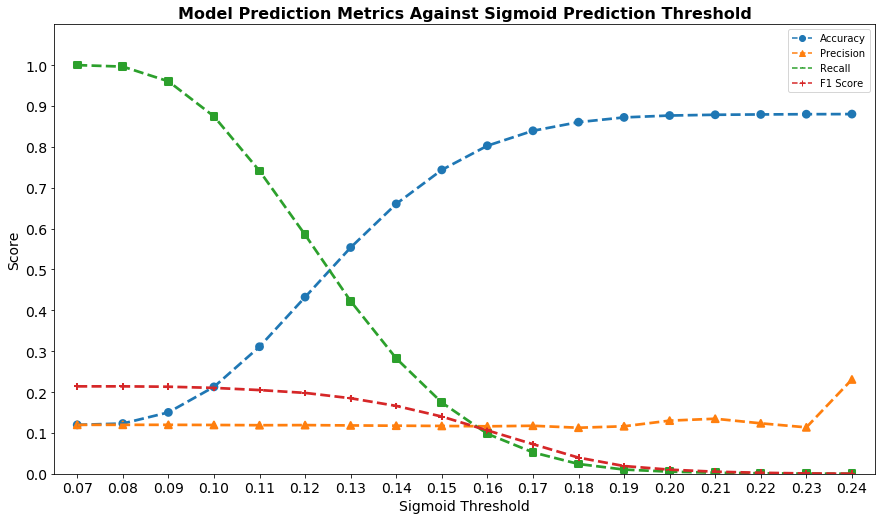

In [56]:
thresholds = np.arange(0.07,0.25,0.01)
labels = ["{:.2f}".format(i) for i in thresholds]

accuracies = [mod.predictAccuray(mod.predict(X_train, theta_opt03_2000, i), y_train, pcnt=False) for i in thresholds]
precisions = [mod.precision(mod.predict(X_train, theta_opt03_2000, i), y_train) for i in thresholds]
recalls = [mod.recall(mod.predict(X_train, theta_opt03_2000, i), y_train) for i in thresholds]
f1s = [mod.f1score(mod.predict(X_train, theta_opt03_2000, i), y_train) for i in thresholds]

c=sb.color_palette()

vis.createPlot(ylabel="Score", xlabel="Sigmoid Threshold");
sb.pointplot(x=thresholds, y=accuracies, linestyles='--', color=c[0], markers='o')
sb.pointplot(x=thresholds, y=precisions, linestyles='--', color=c[1], markers='^')
sb.pointplot(x=thresholds, y=recalls, linestyles='--', color=c[2], markers=',')
sb.pointplot(x=thresholds, y=f1s, linestyles='--', color=c[3], markers='+')

import matplotlib.lines as mlines

l0 = mlines.Line2D([],[], linestyle='--', color=c[0], marker='o')
l1 = mlines.Line2D([],[], linestyle='--', color=c[1], marker='^')
l2 = mlines.Line2D([],[], linestyle='--', color=c[2], marker=',')
l3 = mlines.Line2D([],[], linestyle='--', color=c[3], marker='+')


plt.legend((l0,l1,l2,l3), ("Accuracy","Precision", "Recall", "F1 Score"));

locs, _ = plt.xticks()
plt.xticks(locs, labels);
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Model Prediction Metrics Against Sigmoid Prediction Threshold", fontsize=16, fontweight='bold');
plt.ylim(0,1.1)

### Interpretation
* The highest accuracy is achieved when the model predicts **all** users do not convert
* The highest recall is achieved when the model predicts **all** users do convert
* The model precision remains fairly constant across the span of sigmoid thresholds
* The $F_1$ score starts to trend toward zero whent he sigmoid threshold is 0.12.

Finding the optimum balance of model performance depends on the business priorities. If the model is used for identifying the users who are most likely to make a purchase for marketing purposes, reducing the number of false negative predictions would probably be beneficial, therefore maximising recall would be sensible. Maximum recall is achieved when **all** users are predicted to make a purchase which is clearly not practical. A 50:50 balance between recall and model accuracy occurs when the sigmoid threshold is 0.125. At this point, the $F_1$ score has not deteriorated much either, therefore we'll select this value as our prediction threshold. 
***
Lets now test our optimised parameters on the test set to measure performance.

In [58]:
predict_train = mod.predict(X_train, theta_opt03_2000, threshold=0.125)
predict_test = mod.predict(X_test, theta_opt03_2000, threshold=0.125)

f1_train = mod.f1score(predict_train, y_train)
f1_test = mod.f1score(predict_test, y_test)

train_acc = mod.predictAccuray(predict_train, y_train)
test_acc = mod.predictAccuray(predict_test, y_test)

print("Training Accuracy:{}, F1 Score:{}".format(train_acc, f1_train))
print("Test Accuracy:{}, F1 Score:{}".format(test_acc, f1_test))

Training Accuracy:49.43%, F1 Score:0.1921741725703335
Test Accuracy:49.65%, F1 Score:0.19159007606873812


In [59]:
predict_train = mod.predict(X_train, theta_opt03, threshold=0.125)
predict_test = mod.predict(X_test, theta_opt03, threshold=0.125)

f1_train = mod.f1score(predict_train, y_train)
f1_test = mod.f1score(predict_test, y_test)

train_acc = mod.predictAccuray(predict_train, y_train)
test_acc = mod.predictAccuray(predict_test, y_test)

print("Training Accuracy:{}, F1 Score:{}".format(train_acc, f1_train))
print("Test Accuracy:{}, F1 Score:{}".format(test_acc, f1_test))

Training Accuracy:46.62%, F1 Score:0.19408036337187726
Test Accuracy:46.66%, F1 Score:0.19446706047430146


In [59]:
theta_opt03_2000, theta_opt03

(array([-0.94455336, -0.19689719, -0.13416713, -0.35716857, -0.45321765,
        -0.0225541 , -0.01638714]),
 array([-0.37792756, -0.15353466, -0.03004187, -0.1168567 , -0.23102899,
        -0.05753789, -0.04293885]))

In [23]:
# Prediction with theta optimised with 500 iterations
predict_train500 = mod.predict(X_train, theta_opt03)
predict_test500 = mod.predict(X_test, theta_opt03)

# Predictions with theta optimised with 2000 iterations
predict_train2000 = mod.predict(X_train, theta_opt03_2000)
predict_test2000 = mod.predict(X_test, theta_opt03_2000)

In [24]:
print("500 iterations ->", "train:", mod.predictAccuray(predict_train500, y_train), 
          "test:", mod.predictAccuray(predict_test500, y_test))
print("2000 iteration ->", "train:", mod.predictAccuray(predict_train2000, y_train), 
          "test:", mod.predictAccuray(predict_test2000, y_test))

500 iterations -> train: 88.02% test: 88.09%
2000 iteration -> train: 88.02% test: 88.09%


In [27]:
mod.sigmoid(X_train, theta_opt03)

array([0.13298843, 0.25103131, 0.12488387, ..., 0.07187819, 0.18455812,
       0.18124888])

In [46]:
mod.sigmoid(X_train, theta_opt03_2000).min()

0.07653980079999573

In [30]:
y_train == 1

array([False, False, False, ..., False, False, False])

There is no difference between the prediction accuracy using theta optimised through 500 and 2000 iterations. The prediction accuracy on the test is marginally higher than our train dataset. This tells us that are model is not overfitting the data so there is no need for regularisation.

## Plan
* Add and remove features, identify significant features
* Repeat assessment using scikit learn.

In [278]:
df_test.head()

,intercept,group,CA,UK,US,day,hour,converted
2,1,1,0,0,1,11,16,0
5,1,0,0,0,1,10,15,0
7,1,0,0,0,1,17,1,0
9,1,1,1,0,0,15,18,1
13,1,1,0,0,1,22,1,0


In [287]:
X_train_day = df_train.iloc[:,:-2]
theta = np.zeros(X_train_day.shape[1])

theta_opt_day = mod.gradientDescent(X_train_day, theta, y_train, alpha=0.03, iters=500)
mod.predictAccuray(mod.predict(X_train_day,theta_opt_day), y_train)

'88.02%'

In [288]:
X = df_train.iloc[:,:-3]
theta = np.zeros(X.shape[1])

theta_opt = mod.gradientDescent(X, theta, y_train, alpha=0.03, iters=500)
mod.predictAccuray(mod.predict(X,theta_opt), y_train)

'88.02%'

In [299]:
X = df_train.iloc[:,[0,1,5,6]]
theta = np.zeros(X.shape[1])

theta_opt = mod.gradientDescent(X, theta, y_train, alpha=0.03, iters=500)
mod.predictAccuray(mod.predict(X,theta_opt), y_train)

'88.02%'

In [295]:
X = df_train.iloc[:,[0]]
theta = np.zeros(X.shape[1])

theta_opt = mod.gradientDescent(X, theta, y_train, alpha=0.03, iters=500)
mod.predictAccuray(mod.predict(X,theta_opt), y_train)

'88.02%'

In [300]:
h = mod.sigmoid(X, theta)
np.dot(X.T,(h-y_train))

array([  77337.5,   38662.5, 1009523.5,  887994. ])

In [301]:
mod.predictAccuray(mod.predict(X,theta), y_train)

'11.98%'